In [85]:
import jittor as jt
import numpy as np
from PIL import Image
from jittor import nn
from skimage import data
from skimage.exposure import match_histograms
from matplotlib import pyplot as plt
import cv2

In [86]:
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [87]:
img = read_img('/home/sgd-2022/datasets/Jittor2023/img.jpg')
ref = read_img('/home/sgd-2022/datasets/Jittor2023/ref.jpg')

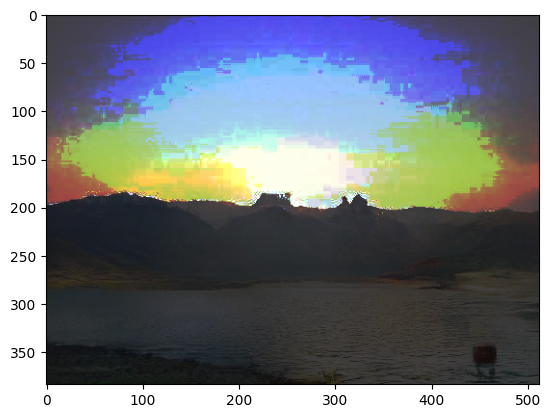

In [88]:
matched = match_histograms(img, ref, channel_axis=-1)
plt.imshow(matched)
plt.show()

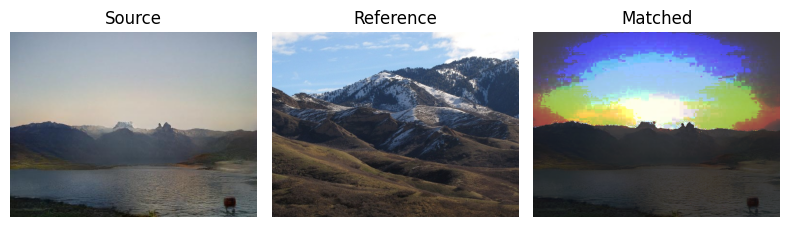

In [89]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True)
for ax in (ax1, ax2, ax3):
    ax.set_axis_off()

ax1.imshow(img)
ax1.set_title('Source')
ax2.imshow(ref)
ax2.set_title('Reference')
ax3.imshow(matched)
ax3.set_title('Matched')

plt.tight_layout()
plt.show()

In [90]:
img = Image.open('/home/sgd-2022/datasets/Jittor2023/img.jpg')
ref = Image.open('/home/sgd-2022/datasets/Jittor2023/ref.jpg')
trans = jt.transform.Compose([jt.transform.ToTensor()])
img = trans(img)
ref = trans(ref)
img = img.reshape(1, *img.shape)
ref = ref.reshape(1, *ref.shape)
imgs = jt.float32(np.concatenate((img, img), axis=0))
refs = jt.float32(np.concatenate((ref, ref), axis=0))
imgs.size(), refs.size()

([2,3,384,512,], [2,3,384,512,])

In [91]:
def getHistMatched(imgs: jt.Var, refs: jt.Var):
    assert imgs.shape == refs.shape
    bs, c, h, w = imgs.shape
    matched_list = []
    for i in range(bs):
        img, ref = imgs.data[i, :, :, :], refs.data[i, :, :, :]
        img = np.array(img * 255, dtype=np.uint8).transpose((1, 2, 0))
        ref = np.array(ref * 255, dtype=np.uint8).transpose((1, 2, 0))
        matched = match_histograms(img, ref, channel_axis=-1)
        matched = matched.transpose((2, 0, 1)) / 255
        matched = matched.reshape(1, *matched.shape)
        matched_list.append(matched)
    matcheds = jt.float32(np.concatenate(matched_list, axis=0))
    matcheds.stop_grad()
    return matcheds

In [97]:
def HistLoss(imgs: jt.Var, refs: jt.Var):
    matcheds = getHistMatched(imgs, refs)
    return nn.L1Loss()(imgs, matcheds)

In [98]:
HistLoss(imgs, refs)

jt.Var([0.17083566], dtype=float32)